<a href="https://colab.research.google.com/github/bfacesar/Atividade_III_Cesar/blob/main/Part%203-%20Agents/07%20-%20LangGraph%20Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chat Básico

**Objetivo:** Receber uma mensagem do usuário e gerar uma resposta com LLM.

Esse é o caso mais básico de uso de LLM em LangGraph.

In [ ]:
# !pip install -U langchain-openai

In [ ]:
# import getpass
# import os
# # https://platform.openai.com/settings/organization/api-keys
# os.environ["OPENAI_API_KEY"] = getpass.getpass()

··········


In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph.message import add_messages

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
from typing import Annotated, TypedDict

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
def chatbot(state: State):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

In [ ]:
builder = StateGraph(State)

builder.add_node("chatbot", chatbot)

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

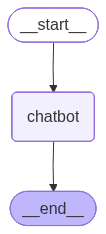

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
response = graph.invoke({
    "messages": [
        HumanMessage(content="Qual é a capital de Pernambuco?"),
    ]
})

In [ ]:
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Qual é a capital de Pernambuco?
================================== Ai Message ==================================

A capital de Pernambuco é Recife.


### Ferramentas

In [ ]:
from langchain.tools import tool

@tool
def get_weather(location: str) -> str:
    """Retorna a previsão do tempo para uma localização específica."""
    return f"A previsão do tempo em {location} é ensolarada com uma temperatura de 25°C."

tools = [get_weather]

In [ ]:
llm_with_tools = llm.bind_tools(tools)

In [ ]:
result = llm_with_tools.invoke("qual é a previsão do tempo em Natal?")
print(result)

content='' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 57, 'total_tokens': 71, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c', 'id': 'chatcmpl-CvqDsW6jLeq9Ipdsj4GQdmGc7Spmx', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='lc_run--019b9f23-b6b1-7411-8191-67595f38afe5-0' tool_calls=[{'name': 'get_weather', 'args': {'location': 'Natal'}, 'id': 'call_n8NSZu0dMhylvkKYRTVcOzli', 'type': 'tool_call'}] invalid_tool_calls=[] usage_metadata={'input_tokens': 57, 'output_tokens': 14, 'total_tokens': 71, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition

def chatbot(state: State):
    messages = state["messages"]
    return {"messages": [llm_with_tools.invoke(messages)]}

tool_node = ToolNode(tools=tools)

In [ ]:
builder = StateGraph(State)

builder.add_node("chatbot", chatbot)
builder.add_node("tools", tool_node)

builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

builder.add_edge("tools", "chatbot")
builder.add_edge(START, "chatbot")

graph = builder.compile()

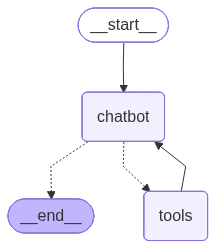

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
response = graph.invoke({
    "messages": [
        HumanMessage(content="Qual é a previsão do tempo em Recife?"),
    ]
})

In [ ]:
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Qual é a previsão do tempo em Recife?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_EZNetU5pLt7yFXvr83q2OAld)
 Call ID: call_EZNetU5pLt7yFXvr83q2OAld
  Args:
    location: Recife
================================= Tool Message =================================
Name: get_weather

A previsão do tempo em Recife é ensolarada com uma temperatura de 25°C.
================================== Ai Message ==================================

A previsão do tempo em Recife é ensolarada, com uma temperatura de 25°C.


## Exercícios

### Exercício 1
Crie um agente que escreva e leia arquivos de texto com o conteúdo solicitado pelo usuário.

In [2]:
!pip -q install -U langgraph langchain-openai langchain-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.4/501.4 kB 25.5 MB/s eta 0:00:00


In [5]:
## Professor para teste, pode usar a KEY abaixo pois vou regova-la após conclusão.
## 
import os, getpass
os.environ["OPENAI_API_KEY"] = getpass.getpass("Cole sua OPENAI_API_KEY (não aparece): ")

Cole sua OPENAI_API_KEY (não aparece): ··········


In [9]:
import os
from typing import TypedDict, Optional

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, END

class AgentState(TypedDict):
    user_input: str
    action: Optional[str]
    filename: Optional[str]
    content: Optional[str]
    result: Optional[str]

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=90
)

def decide_action(state: AgentState):
    system = SystemMessage(content=(
        "Converta o pedido do usuário em comando para manipular arquivos .txt.\n"
        "Responda SOMENTE no formato abaixo (máximo 3 linhas):\n"
        "ACTION: write|read\n"
        "FILENAME: <nome>.txt\n"
        "CONTENT: <texto> (apenas se ACTION=write)\n"
        "Sem explicações."
    ))
    human = HumanMessage(content=state["user_input"])

    resp = llm.invoke([system, human]).content.strip()

    action = None
    filename = None
    content = None

    for line in resp.splitlines():
        line = line.strip()
        if line.upper().startswith("ACTION:"):
            action = line.split(":", 1)[1].strip().lower()
        elif line.upper().startswith("FILENAME:"):
            filename = line.split(":", 1)[1].strip()
        elif line.upper().startswith("CONTENT:"):
            content = line.split(":", 1)[1].strip()

    return {"action": action, "filename": filename, "content": content}

def write_file(state: AgentState):
    filename = state.get("filename") or "arquivo.txt"
    content = state.get("content") or ""
    with open(filename, "w", encoding="utf-8") as f:
        f.write(content)
    return {"result": f"OK: escrevi o arquivo '{filename}'."}

def read_file(state: AgentState):
    filename = state.get("filename") or "arquivo.txt"
    if not os.path.exists(filename):
        return {"result": f"ERRO: o arquivo '{filename}' não existe."}
    with open(filename, "r", encoding="utf-8") as f:
        txt = f.read()
    return {"result": f"OK: conteúdo de '{filename}':\n{txt}"}

def route(state: AgentState):
    if state.get("action") == "write":
        return "write_file"
    if state.get("action") == "read":
        return "read_file"
    return END

graph = StateGraph(AgentState)
graph.add_node("decide_action", decide_action)
graph.add_node("write_file", write_file)
graph.add_node("read_file", read_file)

graph.set_entry_point("decide_action")
graph.add_conditional_edges(
    "decide_action",
    route,
    {"write_file": "write_file", "read_file": "read_file", END: END}
)
graph.add_edge("write_file", END)
graph.add_edge("read_file", END)

app = graph.compile()

print(app.invoke({"user_input": "Crie o arquivo CesarSchool.txt com o conteúdo: Olá, arquivo criado com sucesso!"})["result"])
print(app.invoke({"user_input": "Leia o arquivo CesarSchool.txt"})["result"])

print(app.invoke({"user_input": "Leia o arquivo CesarOutro.txt" })["result"]
)

OK: escrevi o arquivo 'CesarSchool.txt'.
OK: conteúdo de 'CesarSchool.txt':
Olá, arquivo criado com sucesso!
ERRO: o arquivo 'CesarOutro.txt' não existe.
